In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv

In [4]:
%matplotlib inline

# Summary

### Available Data
- Congress trade results (cleaned and calculated gains)
- Congress committee membership
-Stock Meta Data

### Goal:
- join dataframes together so that congress committees are associated with the respective congress person's trading record
- join stock meta data to trading records as well
- explore data and determine non-null records we have after all merging is completed
- use Google's universal sentence encoder to determine semantic similarity between commitee and stock meta information

In [5]:
committees_df = pd.read_csv("../data/politican_and_committees.csv")
# print(committees_df.head())
print(committees_df.info())

committees_names = committees_df["name"].unique()
# iit makes sense that thee are 531 rows in the datset. As there are 535 total members currently, we are missing data on three people. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531 entries, 0 to 530
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   name             531 non-null    object
 1   bioguide         531 non-null    object
 2   committee_codes  531 non-null    object
 3   committee_names  531 non-null    object
dtypes: object(4)
memory usage: 16.7+ KB
None


In [6]:
# merge committee to congress trades
results_df = pd.read_csv("../data/congress_trade_results_05-03-24.csv")
results_df.rename(columns={"Representative": "name"}, inplace=True)

print(results_df.head())

# remove leading and trailing spaces from names
results_df["name"] = results_df.apply(lambda row: row["name"].strip(), axis=1)
congress_trades_names = results_df["name"].unique()
print(congress_trades_names)
print(f"{len(congress_trades_names)} Congress members placed trades")

                        name Ticker  realized_gain  unrealized_gain  \
0  A. Mitchell Jr. McConnell     IR            NaN              NaN   
1  A. Mitchell Jr. McConnell     KR            NaN            14.19   
2  A. Mitchell Jr. McConnell    WFC            NaN            45.79   
3         Abigail Spanberger    LHX            NaN              NaN   
4             Adam B. Schiff   ABBV            NaN              NaN   

   realized_gain_per_year  unrealized_gain_per_year  
0                     NaN                       NaN  
1                     NaN                  9.947980  
2                     NaN                  6.882633  
3                     NaN                       NaN  
4                     NaN                       NaN  
['A. Mitchell Jr. McConnell' 'Abigail Spanberger' 'Adam B. Schiff'
 'Adam Kinzinger' 'Alan S. Lowenthal' 'Andrew Garbarino' 'Angus King'
 'Anthony E. Gonzalez' 'Ashley Hinson Arenholz' 'Aston Donald Mceachin'
 'August Lee Pfluger Ii' 'Austin Scott' 

In [7]:
# 
merged_trades = results_df.merge(committees_df,how="inner",on="name")
print(merged_trades.info())
merged_trade_names = merged_trades["name"].unique()
print(f"{len(merged_trade_names)} names were merged")
matched_names = merged_trades["name"].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2842 entries, 0 to 2841
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      2842 non-null   object 
 1   Ticker                    2842 non-null   object 
 2   realized_gain             1138 non-null   float64
 3   unrealized_gain           1468 non-null   float64
 4   realized_gain_per_year    1136 non-null   float64
 5   unrealized_gain_per_year  1468 non-null   float64
 6   bioguide                  2842 non-null   object 
 7   committee_codes           2842 non-null   object 
 8   committee_names           2842 non-null   object 
dtypes: float64(4), object(5)
memory usage: 200.0+ KB
None
85 names were merged


In [8]:
# only 85 names were successfully merged. There are descrepancies between the formating of commitee names and results names
from fuzzywuzzy import fuzz, process

def fuzzy_match_names(name, choices, threshold=80):
    """
    Perform fuzzy matching for a given name against a list of choices.
    """
    match, score = process.extractOne(name, choices, scorer=fuzz.ratio)
    if score >= threshold:
        return match
    else:
        return None


trade_names_unmatched = [name for name in congress_trades_names if name not in matched_names]
committee_names_unmatched = [name for name in committees_names if name not in matched_names]

print(f"{len(trade_names_unmatched)=}")
print(f"{len(committee_names_unmatched)=}")

# find fuzzy matches and update committee_names so they correspond to the trade_names
committee_name_to_trade_name = {}

for name in trade_names_unmatched:
    committee_name_match = fuzzy_match_names(name,committee_names_unmatched)
    if committee_name_match:
        committee_name_to_trade_name[committee_name_match] = name

# manually observe matches and exclude incorrect ones
print(committee_name_to_trade_name)
matches_to_exclude = [
    'Christopher A. Coons',
]


for name in matches_to_exclude:
    del committee_name_to_trade_name[name]

committees_df["name"] = committees_df["name"].apply(lambda name: committee_name_to_trade_name[name] if name in committee_name_to_trade_name.keys() else name)
committees_df.head()

/Users/austinpaxton/Documents/dev/AI/congress_trades/venv/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


len(trade_names_unmatched)=121
len(committee_names_unmatched)=445
{'Abigail Davis Spanberger': 'Abigail Spanberger', 'Andrew R. Garbarino': 'Andrew Garbarino', 'August Pfluger': 'August Lee Pfluger Ii', 'Bill Pascrell, Jr.': 'Bill Pascrell Jr.', 'Blake D. Moore': 'Blake Moore', 'Bradley Scott Schneider': 'Bradley S. Schneider', 'Brian J. Mast': 'Brian Mast', 'Carol D. Miller': 'Carol Devine Miller', 'Christopher A. Coons': 'Christopher L. Jacobs', 'Dan Crenshaw': 'Daniel Crenshaw', 'Daniel S. Goldman': 'Daniel Goldman', 'David J. Trone': 'David Trone', 'Donald S. Beyer, Jr.': 'Donald Sternoff  Beyer Jr', 'Frank Pallone, Jr.': 'Frank Pallone Jr.', 'Gary J. Palmer': 'Gary Palmer', 'Gary C. Peters': 'Gary Peters', 'J. French Hill': 'James French Hill', 'Joe Manchin, III': 'Joe Manchin', 'John R. Curtis': 'John Curtis', 'John W. Hickenlooper': 'John Hickenlooper', 'John H. Rutherford': 'John Rutherford', 'Kathy E. Manning': 'Kathy Manning', 'Lloyd Smucker': 'Lloyd K. Smucker', 'Mark E. Gre

,name,bioguide,committee_codes,committee_names
0,Bruce Westerman,W000821,"['HSII', 'HSPW', 'HSPW05', 'HSPW14', 'HSPW02']","['House Committee on Natural Resources', 'Hous..."
1,Raúl M. Grijalva,G000551,"['HSII', 'HSED', 'HSED13', 'HSED14', 'HSII06']","['House Committee on Natural Resources', 'Hous..."
2,Doug Lamborn,L000564,"['HSII', 'HSAS', 'HSAS29', 'HSII06', 'HSAS25',...","['House Committee on Natural Resources', 'Hous..."
3,Grace F. Napolitano,N000179,"['HSII', 'HSPW', 'HSII13', 'HSPW12', 'HSPW14',...","['House Committee on Natural Resources', 'Hous..."
4,Robert J. Wittman,W000804,"['HSII', 'HSII13', 'HSAS', 'HSAS28', 'HSII06',...","['House Committee on Natural Resources', 'Wate..."


In [9]:
# retry merge with fuzzy matched names
merged_trades = results_df.merge(committees_df,how="inner",on="name")
print(f"{len(merged_trade_names)} names were merged")
merged_trades.head()
# 50% more names now. 


85 names were merged


,name,Ticker,realized_gain,unrealized_gain,realized_gain_per_year,unrealized_gain_per_year,bioguide,committee_codes,committee_names
0,Abigail Spanberger,LHX,NaN,NaN,NaN,NaN,S001209,"['HSAG', 'HSAG29', 'HLIG', 'HSAG14', 'HLIG06',...","['House Committee on Agriculture', 'Livestock,..."
1,Adam B. Schiff,ABBV,NaN,NaN,NaN,NaN,S001150,"['HSJU', 'HSJU03']","['House Committee on the Judiciary', 'Courts, ..."
2,Andrew Garbarino,BAC,NaN,NaN,NaN,NaN,G000597,"['HSBA', 'HSBA04', 'HSBA16', 'HSHM', 'HSSO', '...","['House Committee on Financial Services', 'Hou..."
3,Andrew Garbarino,GPS,NaN,4.29,NaN,1.658119,G000597,"['HSBA', 'HSBA04', 'HSBA16', 'HSHM', 'HSSO', '...","['House Committee on Financial Services', 'Hou..."
4,Andrew Garbarino,ORMP,62.25,NaN,85.476739,NaN,G000597,"['HSBA', 'HSBA04', 'HSBA16', 'HSHM', 'HSSO', '...","['House Committee on Financial Services', 'Hou..."


In [10]:
# merge stock descriptions from finviz onto merged_trades using ticker
stock_info_df = pd.read_csv("../data/finviz_4-12-23.csv")
stock_info_df.head()

# only merge relevant information
stock_info_df =stock_info_df[["ticker", "full_name", "sector", "industry"]]
merged_trades.rename({"Ticker":"ticker"}, axis=1, inplace=True)


df = pd.merge(merged_trades, stock_info_df, how="inner", on ="ticker")
df.head()
print(f"{len(merged_trades)=}")
print(f"{len(df)=}")
print(f"Lost {len(merged_trades)-len(df)} trade results")

# df.to_csv("../data/merged_cleaned_results_info.csv", index=False)

len(merged_trades)=3682
len(df)=3454
Lost 228 trade results


## Calculate Semantic Similarity Between Stock Industry and Congress Committees

In [11]:
from sentence_transformers import SentenceTransformer, util

# Load the model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Phrases to compare
phrase1 = "C"
phrase2 = "Reading is my hobby"

# Generate embeddings
embeddings1 = model.encode(phrase1)
embeddings2 = model.encode(phrase2)

# Compute similarity
similarity = util.pytorch_cos_sim(embeddings1, embeddings2)
print(similarity)
print(f"Semantic Similarity: {similarity.item()}")


def calc_semantic_similarity(phrase1, phrase2):
    # Generate embeddings
    embeddings1 = model.encode(phrase1)
    embeddings2 = model.encode(phrase2)

    # Compute similarity
    similarity = util.pytorch_cos_sim(embeddings1, embeddings2)
    
    return similarity.item()
    


/Users/austinpaxton/Documents/dev/AI/congress_trades/venv/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tensor([[0.1341]])
Semantic Similarity: 0.1340591013431549


In [28]:
import ast

committee_names = df["committee_names"].iloc[0]
print(type(committee_names))
def convert_committee_string_to_list(input_str):
    # Convert the string representation of the list back into an actual list
    return ast.literal_eval(input_str)

committee_names = convert_committee_string_to_list(committee_names)
print(type(committee_names))
print(committee_names)

<class 'str'>
<class 'list'>
['House Committee on Agriculture', 'Livestock, Dairy, and Poultry', 'House Permanent Select Committee on Intelligence', 'Conservation, Research, and Biotechnology', 'National Intelligence Enterprise', 'Defense Intelligence and Overhead Architecture']


In [29]:
industry = df["industry"].iloc[0]

for committee in committee_names:
    sim = calc_semantic_similarity(committee,industry)
    print(f"{committee} + {industry} -> {sim}")

# reuslts make sense.. Defense Intelligence and Overhead Arhcitecture should have most similarity to Aerospace and Defence stock

House Committee on Agriculture + Aerospace & Defense -> 0.13262034952640533
Livestock, Dairy, and Poultry + Aerospace & Defense -> 0.1471995711326599
House Permanent Select Committee on Intelligence + Aerospace & Defense -> 0.12096428126096725
Conservation, Research, and Biotechnology + Aerospace & Defense -> 0.20890876650810242
National Intelligence Enterprise + Aerospace & Defense -> 0.2634411156177521
Defense Intelligence and Overhead Architecture + Aerospace & Defense -> 0.4737265706062317


In [45]:
# calcualte similarity score between stock and all committees and return max score

def get_max_sim_score(committees: str, stock_info: str):
    sim_scores = []
    if type(committees) == str:
        committees = convert_committee_string_to_list(committees)
    for committee in committees:
        sim_scores.append(calc_semantic_similarity(stock_info, committee))
    return np.array(sim_scores).max()

get_max_sim_score(committee_names, industry)

0.4737265706062317

In [46]:
# merge industry and sector for stock to provide more info for semantic similarity match
df["sector_and_industry"] = df.apply(lambda row: row["sector"]+ ": " + row["industry"],axis=1)

df.head(2)

,name,ticker,realized_gain,unrealized_gain,realized_gain_per_year,unrealized_gain_per_year,bioguide,committee_codes,committee_names,full_name,sector,industry,sector_and_industry
0,Abigail Spanberger,LHX,NaN,NaN,NaN,NaN,S001209,"['HSAG', 'HSAG29', 'HLIG', 'HSAG14', 'HLIG06',...","['House Committee on Agriculture', 'Livestock,...","L3Harris Technologies, Inc.",Industrials,Aerospace & Defense,Industrials: Aerospace & Defense
1,Adam B. Schiff,ABBV,NaN,NaN,NaN,NaN,S001150,"['HSJU', 'HSJU03']","['House Committee on the Judiciary', 'Courts, ...",AbbVie Inc.,Healthcare,Drug Manufacturers - General,Healthcare: Drug Manufacturers - General


In [47]:
df["sim_score"] = df.apply(lambda row: get_max_sim_score(row["committee_names"], row["sector_and_industry"]), axis=1)

df.head()

,name,ticker,realized_gain,unrealized_gain,realized_gain_per_year,unrealized_gain_per_year,bioguide,committee_codes,committee_names,full_name,sector,industry,sector_and_industry,sim_score
0,Abigail Spanberger,LHX,NaN,NaN,NaN,NaN,S001209,"['HSAG', 'HSAG29', 'HLIG', 'HSAG14', 'HLIG06',...","['House Committee on Agriculture', 'Livestock,...","L3Harris Technologies, Inc.",Industrials,Aerospace & Defense,Industrials: Aerospace & Defense,0.431035
1,Adam B. Schiff,ABBV,NaN,NaN,NaN,NaN,S001150,"['HSJU', 'HSJU03']","['House Committee on the Judiciary', 'Courts, ...",AbbVie Inc.,Healthcare,Drug Manufacturers - General,Healthcare: Drug Manufacturers - General,0.162360
2,Andrew Garbarino,BAC,NaN,NaN,NaN,NaN,G000597,"['HSBA', 'HSBA04', 'HSBA16', 'HSHM', 'HSSO', '...","['House Committee on Financial Services', 'Hou...",Bank of America Corporation,Financial,Banks - Diversified,Financial: Banks - Diversified,0.506707
3,Andrew Garbarino,GPS,NaN,4.29,NaN,1.658119,G000597,"['HSBA', 'HSBA04', 'HSBA16', 'HSHM', 'HSSO', '...","['House Committee on Financial Services', 'Hou...","The Gap, Inc.",Consumer Cyclical,Apparel Retail,Consumer Cyclical: Apparel Retail,0.228080
4,Andrew Garbarino,ORMP,62.25,NaN,85.476739,NaN,G000597,"['HSBA', 'HSBA04', 'HSBA16', 'HSHM', 'HSSO', '...","['House Committee on Financial Services', 'Hou...",Oramed Pharmaceuticals Inc.,Healthcare,Biotechnology,Healthcare: Biotechnology,0.165353


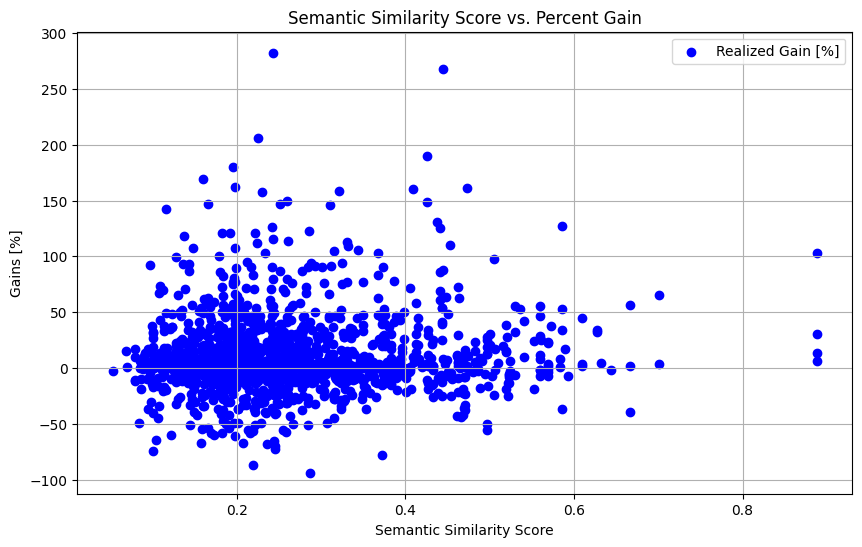

In [51]:
# visualize gains vs. semantic similarity

plt.figure(figsize=(10, 6)) 

plt.scatter(df['sim_score'], df['realized_gain'], color='blue', label='Realized Gain [%]')

# plt.scatter(df['sim_score'], df['unrealized_gain'], color='green', label='Unrealized Gain [%]')


# # Scatter plot for the third dataset
# plt.scatter(df3['x_values'], df3['y_values'], color='green', label='Set 3')

plt.title('Semantic Similarity Score vs. Percent Gain')  # Title of the plot
plt.xlabel('Semantic Similarity Score')  # X-axis label
plt.ylabel('Gains [%]')  # Y-axis label
plt.grid(True)  # Adds a grid
plt.legend()  # Adds a legend to identify the datasets
plt.show()  # Displays the plot

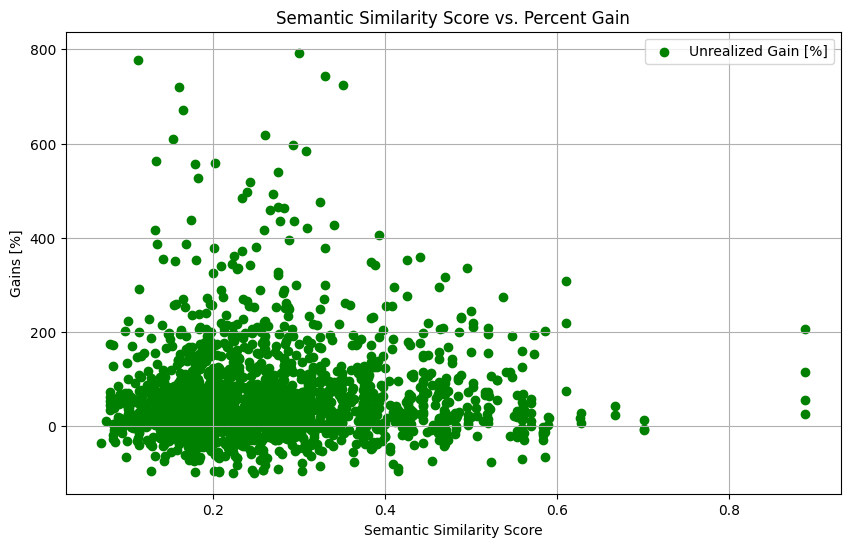

In [54]:
# visualize gains vs. semantic similarity

plt.figure(figsize=(10, 6)) 

# remove outliers with over 1000% unrealized_gain
unrealized_gain_df = df[df["unrealized_gain"]<1000]

plt.scatter(unrealized_gain_df['sim_score'], unrealized_gain_df['unrealized_gain'], color='green', label='Unrealized Gain [%]')


plt.title('Semantic Similarity Score vs. Percent Gain')  # Title of the plot
plt.xlabel('Semantic Similarity Score')  # X-axis label
plt.ylabel('Gains [%]')  # Y-axis label
plt.grid(True)  # Adds a grid
plt.legend()  # Adds a legend to identify the datasets
plt.show()  # Displays the plot

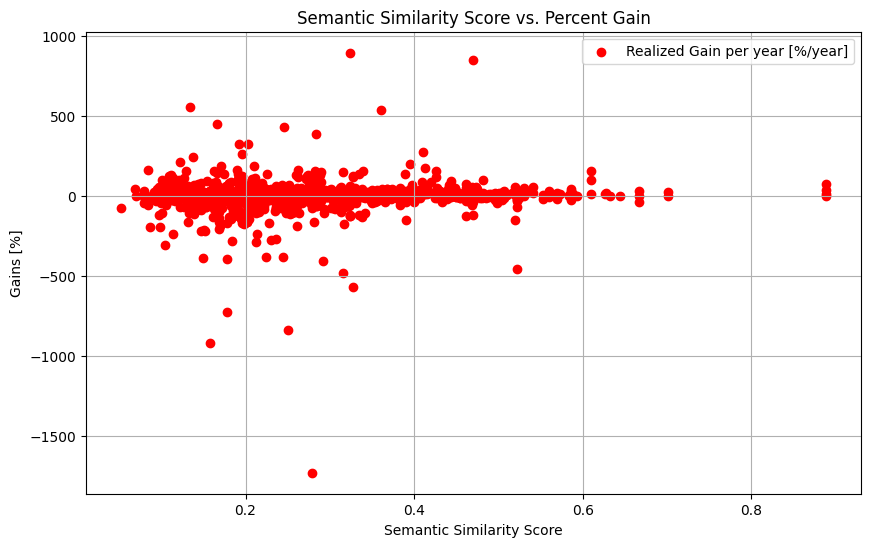

In [55]:
# visualize gains vs. semantic similarity

plt.figure(figsize=(10, 6)) 

# remove outliers with over 1000% realized gain per year
realized_gain_per_year_df = df[df["realized_gain_per_year"]<1000]

plt.scatter(realized_gain_per_year_df['sim_score'], realized_gain_per_year_df['realized_gain_per_year'], color='red', label='Realized Gain per year [%/year]')

plt.title('Semantic Similarity Score vs. Percent Gain')  # Title of the plot
plt.xlabel('Semantic Similarity Score')  # X-axis label
plt.ylabel('Gains [%]')  # Y-axis label
plt.grid(True)  # Adds a grid
plt.legend()  # Adds a legend to identify the datasets
plt.show()  # Displays the plot

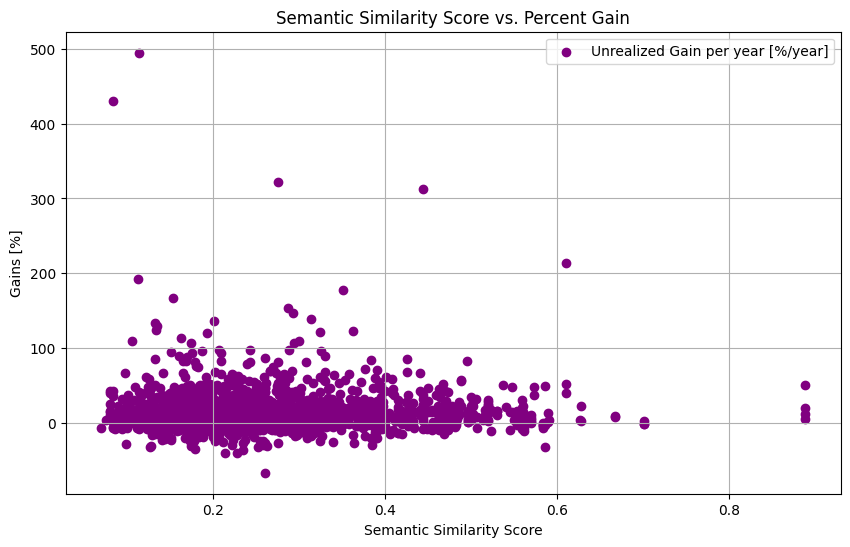

In [58]:
# visualize gains vs. semantic similarity

plt.figure(figsize=(10, 6)) 

# remove outliers with over 1000% realized gain per year
realized_gain_per_year_df = df[df["realized_gain_per_year"]<1000]

plt.scatter(df['sim_score'], df['unrealized_gain_per_year'], color='purple', label='Unrealized Gain per year [%/year]')

plt.title('Semantic Similarity Score vs. Percent Gain')  # Title of the plot
plt.xlabel('Semantic Similarity Score')  # X-axis label
plt.ylabel('Gains [%]')  # Y-axis label
plt.grid(True)  # Adds a grid
plt.legend()  # Adds a legend to identify the datasets
plt.show()  # Displays the plot

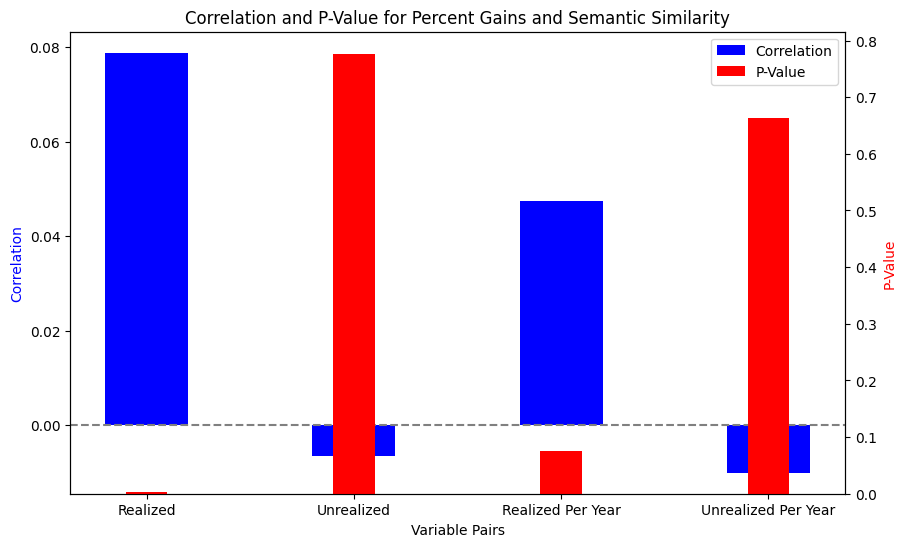

In [71]:
# calculate correlation and p values for all % gains
from scipy.stats import pearsonr

gains_cols = ["realized_gain", "unrealized_gain", "realized_gain_per_year","unrealized_gain_per_year"]
gains_labels =  ["Realized", "Unrealized", "Realized Per Year","Unrealized Per Year"]

results = []

for i,gain in enumerate(gains_cols):
    #filter out null columns 
    temp_df = df[df[gain].notnull()]
    correlation, p_value = pearsonr(temp_df['sim_score'], temp_df[gain])
    results.append([gains_labels[i],correlation,p_value])


# Convert list of tuples to DataFrame
results_df = pd.DataFrame(results, columns=['Label', 'Correlation', 'P_Value'])

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for correlations
correlation_bars = ax1.bar(results_df['Label'], results_df['Correlation'], color='b', label='Correlation', width=0.4)

# Adding a horizontal line at y=0 on the correlation axis
ax1.axhline(0, color='gray', linewidth=1.5, linestyle='--')

# Create a second y-axis for the p-values
ax2 = ax1.twinx()
p_value_bars = ax2.bar(results_df['Label'], results_df['P_Value'], color='r', label='P-Value', width=0.2)


# Adding labels and title
ax1.set_xlabel('Variable Pairs')
ax1.set_ylabel('Correlation', color='b')
ax2.set_ylabel('P-Value', color='r')
ax1.set_title('Correlation and P-Value for Percent Gains and Semantic Similarity')

# Adjusting legend to reflect correct colors
ax1.legend(handles=[correlation_bars, p_value_bars], labels=['Correlation', 'P-Value'])

plt.show()

# Results

The realized gains and semantic similarity score are positively correlated. This is proven by the p-value <0.005. It is interesting that unrealzied gains and unrealized gains per year are negatively correlated to semantic similarity. However, their p-values are bellow 0.005 and not statistically significant. 